Deep artificial neural network for expressive timing predictions in musical pieces
---------------

This notebook loads the data generated from the note level processing notebook and uses them to train and test a long sequence-based artificial neural network for predicting the onset timing deviation of notes from the MusicNet dataset pieces.


#### Load and preprocess training data

In [7]:
import numpy as np
import pandas as pd
import pickle

np.random.seed(1728)

#  read dataset
runLocal = True
if runLocal:
    pathRoot = 'data/'
else:
    pathRoot = '/content/drive/My Drive/colab_data/'

with open(pathRoot + 'note_sequences_voc.data', 'rb') as seq_path:
    sequences = pickle.load(seq_path)
with open(pathRoot + 'note_sequences_dict.data', 'rb') as filehandle:
    lex_to_ix = pickle.load(filehandle)
    ix_to_lex = {v: k for k, v in lex_to_ix.items()}

#### Define the neural network

In [73]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Sequential, Model
from tensorflow.keras.utils import Sequence

def my_model(tx, ty, n_x, n_y, vocab_col, vocab_size):
    X = Input((tx, n_x))
    
    #  Split the input vector between one-hot and numerical features
    mk = list(range(n_x))
    mk.remove(vocab_col)
    
    emb_input = layers.Lambda(lambda x: x[:, :, vocab_col])(X)
    num_input = layers.Lambda(lambda x: tf.gather(x, mk, axis=2))(X)

    #  Compute an embedding vector and combine it with the numeric features
    emb_vec = layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True)(emb_input)
    seq_input = layers.Concatenate(axis=2)([emb_vec, num_input])
    
    #  Run a sequence model
    tensor_var = layers.Bidirectional(layers.LSTM(16, return_sequences = True))(seq_input)
    tensor_var = layers.Dropout(0.2)(tensor_var)
    tensor_var = layers.BatchNormalization()(tensor_var)
    tensor_var = layers.TimeDistributed(layers.Dense(10, activation='relu'))(tensor_var)
    
    
    #  if not 1-to-1, fully-connected layer across time to generate outputs
    if ty < tx:
        tensor_var = layers.Dense(ty, activation='relu')(tensor_var)
        Y = layers.Dense(n_y)(tensor_var)
    else:
        Y = layers.TimeDistributed(layers.Dense(n_y))(tensor_var)
    return Model(inputs=X, outputs=Y)

In [81]:

class DataGenerator(Sequence):
    def __init__(self, data, sequence_length, batch_size=25, sequence_stride=20,
                 shuffle=None, fit=True, output_sequence=True, output_cols=None):
        self.data = data
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.sequence_stride = sequence_stride
        self.shuffle = fit if shuffle is None else shuffle
        self.fit = fit
        self.output_sequence = output_sequence
        self.pad_value = 0.
        self.indexes = []
        if output_cols is None:
            self.output_cols = data[0][1].columns
        else:
            self.output_cols = output_cols
        for si, (x, _, _) in enumerate(data):
            tx = x.shape[0]
            xind = 0
            while tx > sequence_length:
                self.indexes.append((si, xind))
                xind += sequence_stride
                tx -= sequence_stride
            self.indexes.append((si,xind))
        self.on_epoch_end()
        
    def __len__(self):
        return int(len(self.indexes) / self.batch_size)
    
    def __getitem__(self, index):
        index *= self.batch_size
        this_size = self.batch_size if index + self.batch_size < len(self.indexes) else len(self.indexes) - index
        X = np.zeros((this_size, self.sequence_length, self.data[0][0].shape[1]))
        Y = np.zeros((this_size, self.sequence_length, len(self.output_cols)))
        for i in range(this_size):
            X[i,:,:], Y[i,:,:] = self.__getsingleitem(index + i)
        if self.fit:
            if self.output_sequence:
                return X, Y
            else:
                return X, Y[:,-1,:]
        else:
            return X
    
    def __getsingleitem(self, index):
        (seq, stride) = self.indexes[index]
        (X, Y, _) = self.data[seq]
        Y = Y.loc[:, self.output_cols]
        if stride+self.sequence_length <= X.shape[0]:
            if self.fit:
                X = X.iloc[stride:stride+self.sequence_length, :].to_numpy(dtype='float64')
                if self.output_sequence:
                    Y = Y.iloc[stride:stride+self.sequence_length, :].to_numpy(dtype='float64')
                else:
                    Y = Y.iloc[stride+self.sequence_length-1, :].to_numpy(dtype='float64').reshape((1,len(self.output_cols)))
                return X, Y
            else:
                return X.iloc[stride:stride+self.sequence_length, :].to_numpy(dtype='float64')
        else:
            # pad
            X = X.iloc[stride:X.shape[0], :].to_numpy(dtype='float64')
            padX = np.full((self.sequence_length - X.shape[0], X.shape[1]), self.pad_value)
            if self.fit:
                if self.output_sequence:
                    Y = Y.iloc[stride:Y.shape[0], :].to_numpy(dtype='float64')
                    padY = np.full((self.sequence_length - Y.shape[0], Y.shape[1]), self.pad_value)
                    return np.concatenate((X, padX), axis=0), np.concatenate((Y, padY), axis=0)
                else:
                    padY = np.full((1, Y.shape[1]), self.pad_value)
            else:
                return np.concatenate((X, padX), axis=0).reshape((1, self.sequence_length, X.shape[1]))
    
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

            
seq_length = 20
output_cols = ['timingDevLocal', 'peakLevel']
# small ds for testing
sequences = sequences[:10]
val_split_ix = int(0.8*len(sequences))
generator = DataGenerator(sequences[:val_split_ix], seq_length, output_sequence=True, output_cols=output_cols)
val_gen = DataGenerator(sequences[val_split_ix:], seq_length, output_sequence=True, output_cols=output_cols)

model = my_model(seq_length, seq_length, sequences[0][0].shape[1], len(output_cols),
                 sequences[0][0].columns.get_loc("melody"), len(ix_to_lex) + 2)

opt = tf.keras.optimizers.Adam(learning_rate=0.01) #, clipnorm=0.001)
model.compile(loss="mean_absolute_error", optimizer=opt)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 20, 20)]     0                                            
__________________________________________________________________________________________________
lambda_37 (Lambda)              (None, 20)           0           input_20[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 20, 16)       11920       lambda_37[0][0]                  
__________________________________________________________________________________________________
lambda_38 (Lambda)              (None, 20, 19)       0           input_20[0][0]                   
____________________________________________________________________________________________

#### Train the model

In [ ]:
model.fit(generator, epochs=100, validation_data=val_gen)

#  Save model
# model.save_weights('timing2020-08-03_timing.h5')

#### Results

In [85]:
# Load model
#model.load_weights('timing2020-08-03_timing.h5')

#  Compute note-level error
with open(pathRoot + 'note_sequences_test_voc.data', 'rb') as seq_path:
    test_sequences = pickle.load(seq_path)

def evaluation(sequences, sequence_length, model, pad_value=0.):
    Yhat = []
    for (X, _, _) in sequences:
        tx = X.shape[0]
        n_x = int(tx / sequence_length) + 1
        xind = 0
        x = np.full((n_x, sequence_length, X.shape[1]), pad_value)
        for i in range(n_x - 1):            
            x[i,:,:] = X.iloc[(i * sequence_length):(i + 1) * sequence_length,:].to_numpy()
        x[n_x - 1,:tx - (n_x - 1) * sequence_length,:] = X.iloc[(n_x - 1) * sequence_length:,:].to_numpy()
        y = model.predict(x)
        Yhat.append(y.reshape((-1,y.shape[2])))
    return Yhat

def sliding_evaluation(sequences, sequence_length, model, pad_value=-1., pad_start=True):
    Yhat = []
    for (X, _, _) in sequences:
      tx = X.shape[0]
      n_x = tx if pad_start else tx - sequence_length + 1
      x = np.full((n_x, sequence_length, X.shape[1]), pad_value)
      if pad_start:
        r = range(0, tx - seq_length)
      else:
        x[0,:,:] = X.iloc[0:seq_length,:].to_numpy()
        r = range(seq_length, tx - seq_length)
      for i in r:
        x[i,:,:] = X.iloc[i:i+seq_length,:].to_numpy()
      y = model.predict(x)
      if pad_start:
        Yhat.append(y[:,-1,:])
      else:
        Yhat.append(np.concatenate((y[0,:,:], y[1:, -1, :])))
    return Yhat

Yhat = evaluation(test_sequences, seq_length, model)
mse = np.zeros((len(test_sequences), Yhat[0].shape[1]))
ms = np.zeros((len(test_sequences), Yhat[0].shape[1]))
for i, (_, Y, _) in enumerate(test_sequences):
    Y = Y.loc[:,output_cols]
    mse[i,:] = np.mean((Yhat[i][:Y.shape[0],:] - Y) ** 2)
    ms[i,:] = np.mean(Y ** 2)
    
print('Test set MSE for y_0: ' + str(np.mean(mse[:,0])) + '     mean square val: ' + str(np.mean(ms[:,0])))
print('Test set MSE for y_1: ' + str(np.mean(mse[:,1])) + '     mean square val: ' + str(np.mean(ms[:,1])))
# print('Test set MSE for y_2: ' + str(np.mean(mse[:,2])) + '     mean square val: ' + str(np.mean(ms[:,2])))

Test set MSE for y_0: 1.2641238176714618     mean square val: 0.9978774293004024
Test set MSE for y_1: 1.6912836506737918     mean square val: 0.9978774293004026


timingDevLocal


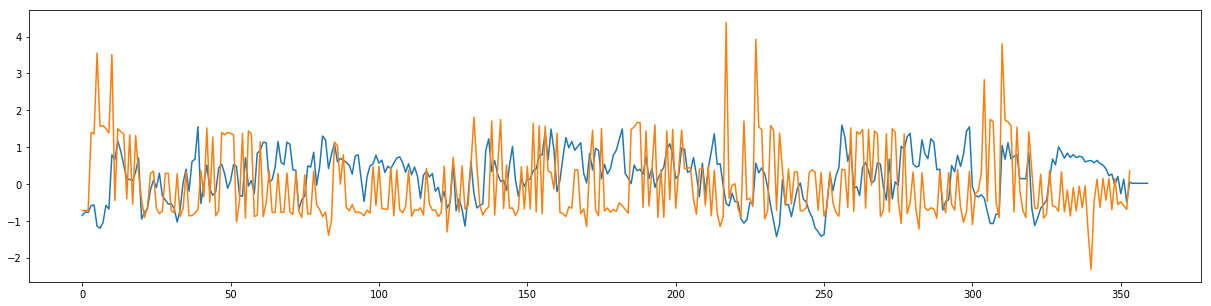

In [87]:
import matplotlib.pyplot as plt

piece = 3
attr = 1 # from 0 to 2
plt.figure(figsize=(21, 5))
plt.plot(Yhat[piece][:,attr])
plt.plot(test_sequences[piece][1].iloc[:,attr].to_numpy())
print(test_sequences[piece][1].columns[attr])
plt.show()